<a href="https://colab.research.google.com/github/shafiqayusaidi/concrete-crack-image-classification/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import sklearn and tensorflow libraries

In [29]:
from tensorflow.keras import datasets, layers, models, losses
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import time
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

NAME = "Concrete-crack-image-classification{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

file_path = r'/content/drive/MyDrive/Concrete Crack Images for Classification'
data_dir = pathlib.Path(file_path)

# Splitting the data set into train-validation-test sets

In [30]:
SEED = 12345
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='training',seed=SEED,image_size=(180,180),batch_size=512)
val_data = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset='validation',seed=SEED,image_size=(180,180),batch_size=512)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


# Creating test set from validation set

In [31]:
# Split validation set, so that we obtain validation and test data
val_batches = tf.data.experimental.cardinality(val_data)
test_dataset = val_data.take(val_batches//5)
validation_dataset = val_data.skip(val_batches//5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of validation batches: 13
Number of test batches: 3


# Checking the image

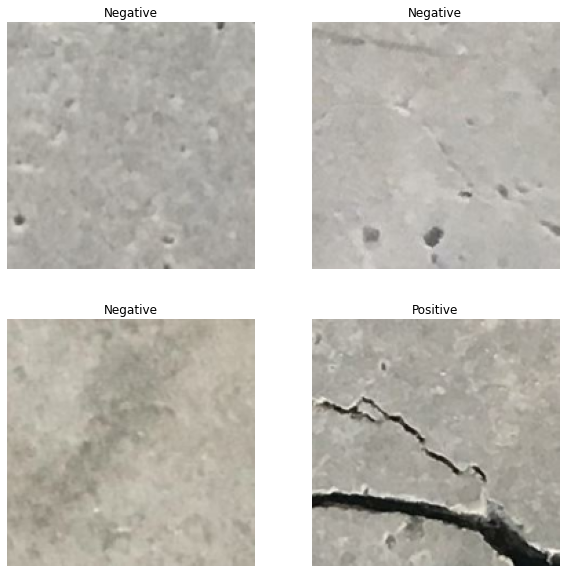

In [32]:
# Check image
class_names = train_dataset.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Configure dataset

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)
# Data preparation is completed

# Creating a base model using MobileNetV2 with transfer learning

In [34]:
# Define a layer that preprocess inputs for the transfer learning model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create base model with MobileNetV2
image_shape =  image_size=(180,180) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,include_top=False,weights='imagenet')

In [35]:
#3.3. Freeze the base model and view the model structure
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [36]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(512, 6, 6, 1280)


# Base Model Architecture

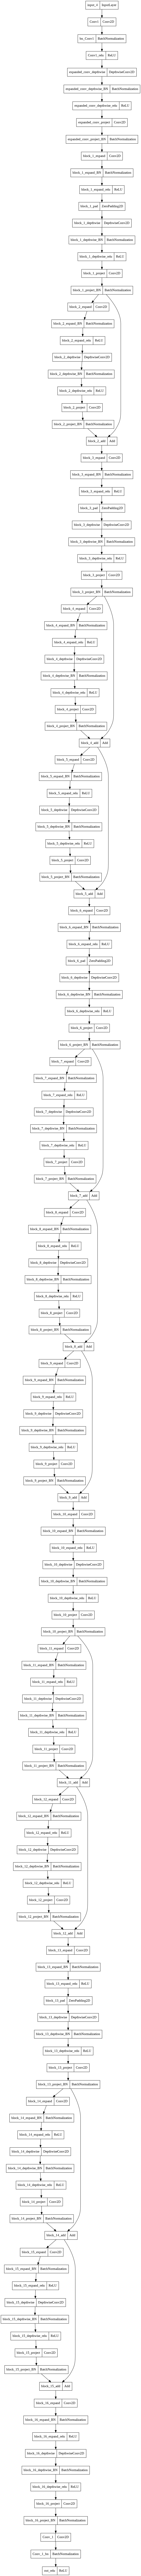

In [37]:
tf.keras.utils.plot_model(base_model)

# Adding a classification layer using Global Average Pooling


In [38]:
# Add classification layer using global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(512, 1280)


In [39]:
# Use the output as it is, no activation function
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(512, 2)


# Use functional API to create the entire model (input pipeline)

In [40]:
inputs = tf.keras.Input(shape=image_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

# Compile the model

In [41]:
# Compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [42]:
# Model performance before training
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

13/13 [==============================] - 18s 583ms/step - loss: 1.5377 - accuracy: 0.4796
initial loss: 1.54
initial accuracy: 0.48


# Train the model with the added dense layer 

In [43]:
# Train the last dense layer we added

import os

logdir = os.path.join("logs", 'model')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
EPOCHS = 10
history = model.fit(train_dataset_pf,
                    epochs=EPOCHS,
                    validation_data=validation_dataset_pf,
                    callbacks=[tensorboard_callback])

Epoch 1/10
63/63 [==============================] - 67s 931ms/step - loss: 0.9224 - accuracy: 0.5357 - val_loss: 0.3919 - val_accuracy: 0.8441
Epoch 2/10
63/63 [==============================] - 71s 1s/step - loss: 0.2853 - accuracy: 0.9020 - val_loss: 0.1513 - val_accuracy: 0.9797
Epoch 3/10
63/63 [==============================] - 65s 935ms/step - loss: 0.1402 - accuracy: 0.9727 - val_loss: 0.0885 - val_accuracy: 0.9893
Epoch 4/10
63/63 [==============================] - 65s 933ms/step - loss: 0.0903 - accuracy: 0.9840 - val_loss: 0.0619 - val_accuracy: 0.9921
Epoch 5/10
63/63 [==============================] - 64s 932ms/step - loss: 0.0671 - accuracy: 0.9883 - val_loss: 0.0472 - val_accuracy: 0.9938
Epoch 6/10
63/63 [==============================] - 64s 931ms/step - loss: 0.0539 - accuracy: 0.9899 - val_loss: 0.0396 - val_accuracy: 0.9943
Epoch 7/10
63/63 [==============================] - 64s 931ms/step - loss: 0.0451 - accuracy: 0.9919 - val_loss: 0.0346 - val_accuracy: 0.9952
Ep

# Evaluate the model

In [44]:
loss, accuracy = model.evaluate(test_dataset_pf)
print('Test accuracy :', accuracy)

3/3 [==============================] - 8s 727ms/step - loss: 0.0291 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


# Make predictions

Predictions:
 [1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0
 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0
 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0
 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0
 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1
 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1
 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0
 0 1 1 0 1 

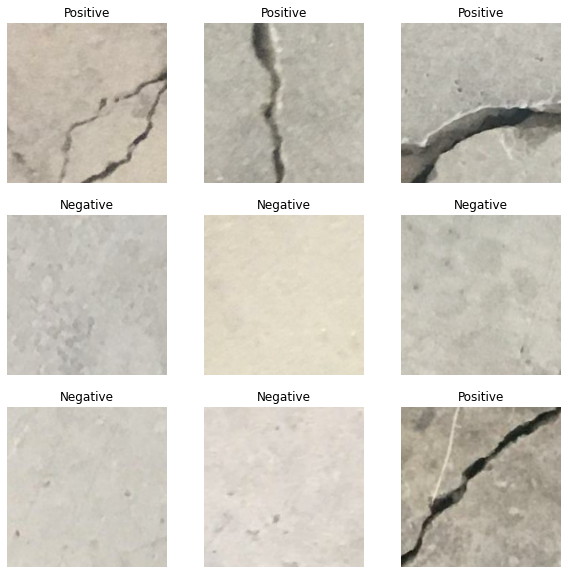

In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset_pf.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
pred_label = np.argmax(predictions, axis=1) # get the class index with max predictions

print('Predictions:\n', pred_label)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_label[i]])
  plt.axis("off")